# Kaggle Titanic Machine Learning Competition

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

passenger_data = pd.read_csv("../input/train.csv")

### Part One: Analyzing Data

At first glance, we notice a few details about our data.

In [47]:
passenger_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Out of these 12 columns, at first glance, it seems to me that columns such as **Age**, **Sex**, **Pclass**, and **Fare** may play a role in determining whether or not someone survived.

First, I will create a graph detailing the relationship between  and the number of individuals who survived.

#### Age vs. Survival Rate

Text(0, 0.5, 'Amount That Survived')

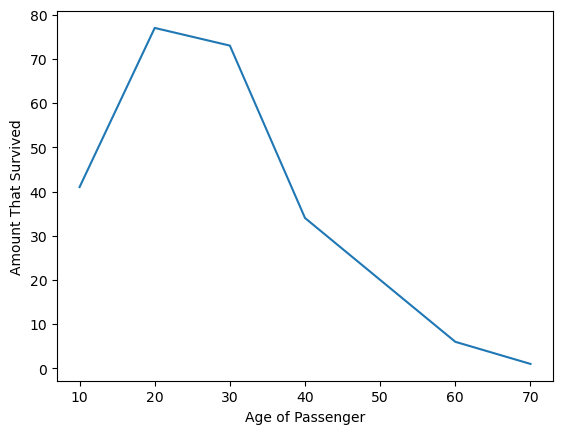

In [48]:
age_groups = [(10, 19), (20, 29), (30, 39), (40, 49), (50, 59), (60, 69), (70, 80)]

amount_survived = []

for start, end in age_groups:
    amount_in_group = passenger_data['Age'][(passenger_data['Age'] >= start) & (passenger_data['Age'] <= end)]
    amount_in_group_survived = amount_in_group[(passenger_data['Survived'] == 1)]
    amount_survived.append(len(amount_in_group_survived))


plt.plot([x[0] for x in age_groups], amount_survived)
plt.xlabel("Age of Passenger")
plt.ylabel("Amount That Survived")

By looking at this example, we see a clear correlation between age and survival. Passengers that were older were less likely to survive. I think that age would be a good feature to incorporate.

#### Passenger Class vs. Survival

Next, I will look at the connection between the class of passengers (1st, 2nd, or 3rd) and determine if that correlates to whether or not they survived.

Text(0, 0.5, 'Amount Survived')

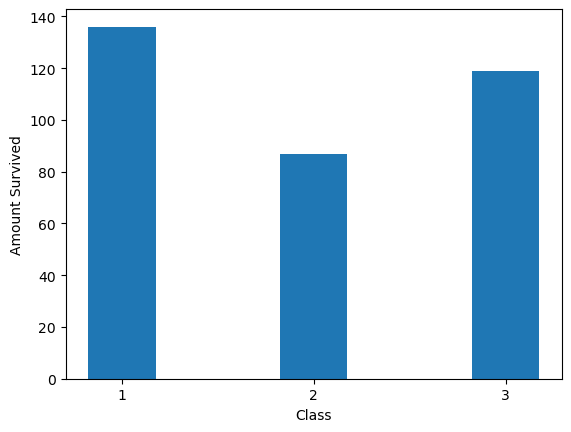

In [49]:
classes = [1, 2, 3]

first_class_survived = len(passenger_data["Pclass"][(passenger_data["Pclass"] == 1) & (passenger_data["Survived"] == 1)]) 
second_class_survived = len(passenger_data["Pclass"][(passenger_data["Pclass"] == 2) & (passenger_data["Survived"] == 1)])
third_class_survived = len(passenger_data["Pclass"][(passenger_data["Pclass"] == 3) & (passenger_data["Survived"] == 1)])

amount_survived_from_class = [first_class_survived, second_class_survived, third_class_survived]

plt.bar(classes, amount_survived_from_class, width=.35)
plt.xticks([1, 2, 3])
plt.xlabel("Class")
plt.ylabel("Amount Survived")

According to this data, there were more people in first class who survived compared to second and third class. This could be useful for our model.

#### Amount Paid for Fare vs. Survival

Next, I will look to see if there are any correlations between the amount a passenger paid for their fare and their survival.

Text(0, 0.5, 'Amount Survived')

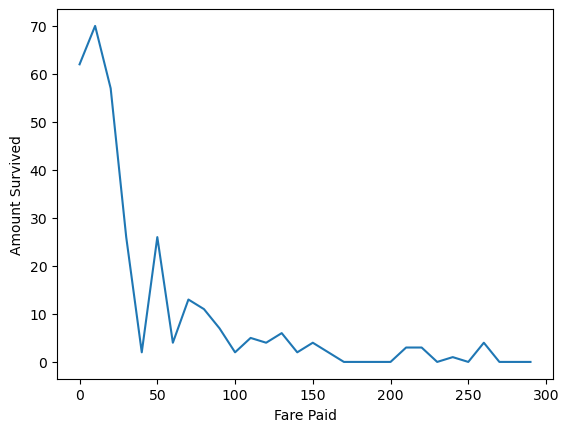

In [50]:
fares_paid = passenger_data['Fare']

fare_ranges = []
initialStart, initialEnd = 0, 9
increment = 10

while initialEnd < 300:
    fare_ranges.append((initialStart, initialEnd))
    initialStart += increment
    initialEnd += increment

amount_survived_fare = []

for start, end in fare_ranges:
    fare_group = passenger_data['Fare'][(passenger_data['Fare'] >= start) & (passenger_data['Fare'] <= end)]
    fare_group_survived = fare_group[(passenger_data['Survived'] == 1)]
    amount_survived_fare.append(len(fare_group_survived))

plt.plot([x[0] for x in fare_ranges], amount_survived_fare)
plt.xlabel("Fare Paid")
plt.ylabel("Amount Survived")

We reach an interesting conclusion. The passengers that paid higher fares had a less amount of people survive. This is plausible, but first we must think about the data. It is likely that there was fewer "upper" class passengers who paid more. Let's rework this. What if instead of using the total number of passengers survived, we use the ratio of the amount of passengers who **did not** survive in a certain "fare group" to the total amount of passengers in such group?

Text(0, 0.5, 'Percentage Survived')

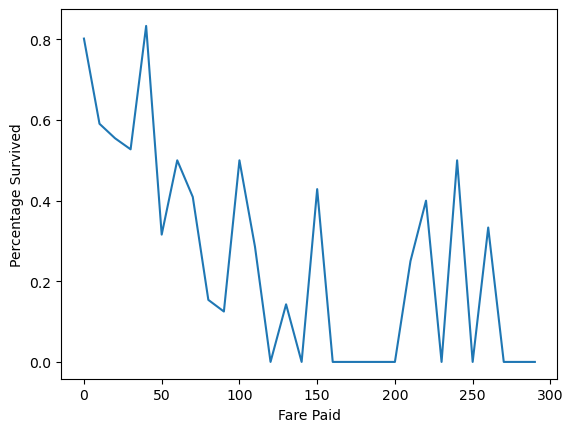

In [51]:
fare_ranges = []
initialStart, initialEnd = 0, 9
increment = 10

while initialEnd < 300:
    fare_ranges.append((initialStart, initialEnd))
    initialStart += increment
    initialEnd += increment

amount_survived_fare_ratio = []

for start, end in fare_ranges:
    fare_group = passenger_data['Fare'][(passenger_data['Fare'] >= start) & (passenger_data['Fare'] <= end)]
    fare_group_survived = fare_group[(passenger_data['Survived'] == 0)]
    ratio_survived = (len(fare_group_survived) / len(fare_group)) if len(fare_group) > 0 else 0
    amount_survived_fare_ratio.append(ratio_survived)

plt.plot([x[0] for x in fare_ranges], amount_survived_fare_ratio)
plt.xlabel("Fare Paid")
plt.ylabel("Percentage Survived")

We still see a trend. Those who paid more, on average, has a lower survival rate. Interesting.

#### Sex vs. Survival

Last, I will examine if there exists a correlation between the sex of the passengers and the survival rate. First, I will group the data by sex.

Text(0, 0.5, 'Percentage Survived')

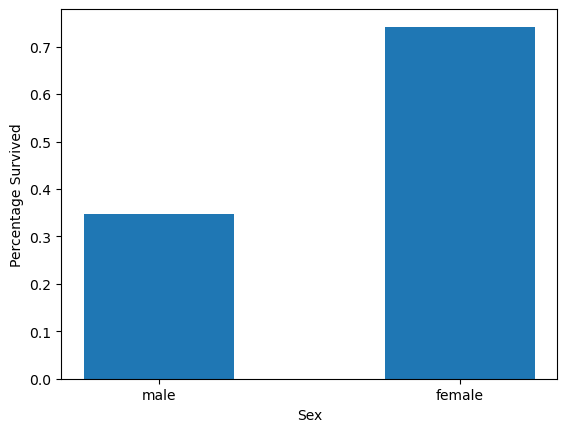

In [52]:
males_survived = len(passenger_data['Sex'][(passenger_data['Sex'] == "male") & (passenger_data['Survived'] == 1)])
females_survived = len(passenger_data['Sex'][(passenger_data['Sex'] == "female") & (passenger_data['Survived'] == 1)])

total_males = len(passenger_data['Sex'][(passenger_data['Sex'] == "male")])
total_females = len(passenger_data['Sex'][(passenger_data['Sex'] == "female")])

males_survival_rate = males_survived / total_females
female_survival_rate = females_survived / total_females

plt.bar(["male", "female"], [males_survival_rate, female_survival_rate], width=0.5)
plt.xlabel("Sex")
plt.ylabel("Percentage Survived")

This is a significant finding. Over 70% of women in the dataset survived, compared to around 35% of men!

### Part Two: Constructing a Model

We now have a list of features that we wish to use: Age, Sex, and Fare. Let's start building our model!
First, I will create a new column named "Sex_numerical" that represents the sex of the passenger with a numerical value. In this case, males are represented with a "1", and females with a "0".

In [53]:
passenger_data['Sex_numerical'] = np.where(passenger_data['Sex'] == 'male', 1, 0)

Now that I have accounted for the "Sex" column, there is another issue. I wish to use age in my model, however some rows have NAN instead of an age. I will have to deal with this. I create a new column called "Age_imputed" that populates all of the NaN rows with the mean age of all passengers.

In [54]:
mean_age = passenger_data['Age'].mean()

#imputating
passenger_data["Age_imputated"] = np.where(passenger_data['Age'].isnull(), mean_age, passenger_data['Age'])

In [68]:
features = ['Sex_numerical', "Age_imputated", "Fare"]

x = passenger_data[features]

label = passenger_data['Survived']

x_train, x_validate, y_train, y_validate = train_test_split(x, label, test_size=0.11, random_state=1)

model = LinearRegression()
model.fit(x_train, y_train)

predictions = model.predict(x_validate)
mean_absolute_error(y_validate, predictions)

0.3111148228066558

After creating our model, we have a MAE of 0.33
Not too bad..

### Using Our Model on Test Data Set

First, we import our test data:

In [56]:
test_data = pd.read_csv("../input/test.csv")

In [66]:
mean_age = test_data['Age'].mean()
test_data['Sex_numerical'] = np.where(test_data['Sex'] == 'male', 1, 0)
test_data["Age_imputated"] = np.where(test_data['Age'].isnull(), mean_age, test_data['Age'])

x = test_data[features]

def handleRound(val):
    if val < 0.5:
        return 0
    else: return 1

predictions = model.predict(x)
predictions = [handleRound(x) for x in predictions]

In [61]:
output = pd.DataFrame({
    "PassengerId": test_data.PassengerId,
    "Survived": predictions
})
output.to_csv("submission.csv", index=False)